# PART 1: Using a Pre-trained ViT for Image Classification

Processing Image 1...


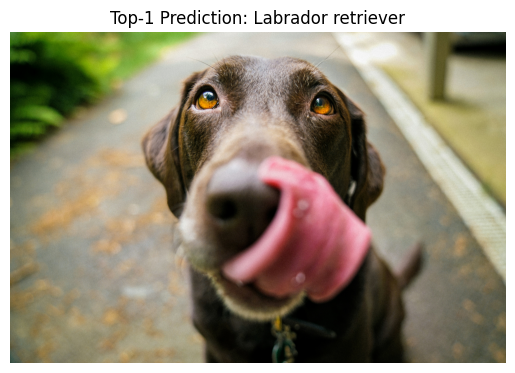

Processing Image 2...


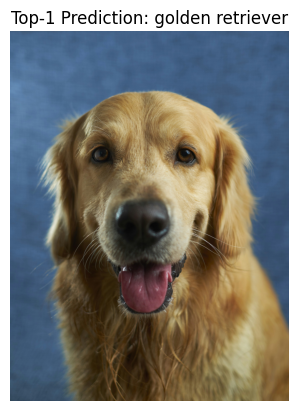

Processing Image 3...


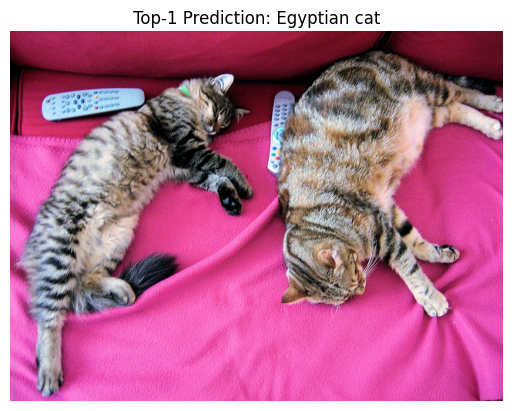

Top-1 Predictions for all images: ['Labrador retriever', 'golden retriever', 'Egyptian cat']


In [14]:
from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, AutoImageProcessor
from io import BytesIO

# --- Model setup ---
model_name = "google/vit-base-patch16-224"
processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)
model = ViTForImageClassification.from_pretrained(model_name, output_attentions=True)
model.eval()

# --- 3 animal/bird images with direct .jpg URLs ---
image_urls = [
    "https://images.unsplash.com/photo-1518717758536-85ae29035b6d?ixlib=rb-4.0.3&q=80",  # dog
    "https://images.unsplash.com/photo-1558788353-f76d92427f16?ixlib=rb-4.0.3&q=80",  # bird
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/coco_sample.png"   # tiger
]

# --- Safe image loading ---
def load_image_from_url(url):
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    return image

# --- Classify a single image ---
def classify_image(image_url):
    try:
        image = load_image_from_url(image_url)
    except Exception as e:
        print(f"Failed to load image from {image_url}: {e}")
        return None, None, None, None

    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    top1_idx = logits.argmax(dim=-1).item()
    top1_label = model.config.id2label[top1_idx]

    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Top-1 Prediction: {top1_label}")
    plt.show()

    return top1_label, image, inputs, outputs

# --- Run on all images ---
predictions = []
results = []

for i, url in enumerate(image_urls):
    print(f"Processing Image {i+1}...")
    pred, image, inputs, outputs = classify_image(url)
    if pred is not None:
        predictions.append(pred)
        results.append((image, inputs, outputs))

print("Top-1 Predictions for all images:", predictions)


# PART 2: Visualizing Patch Attention (CLS Token)

Visualizing attention for Image 1


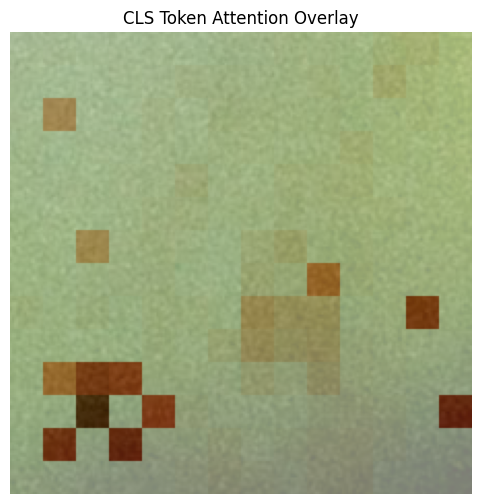

Visualizing attention for Image 2


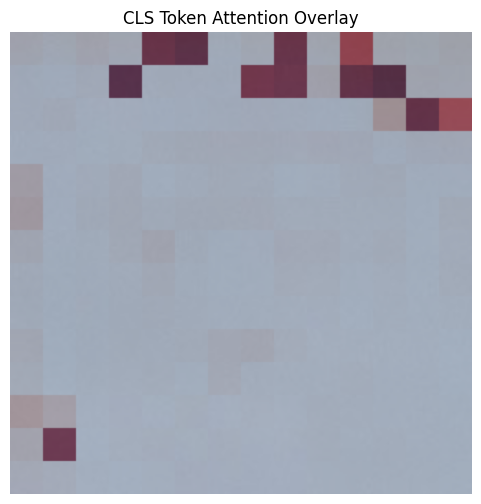

Visualizing attention for Image 3


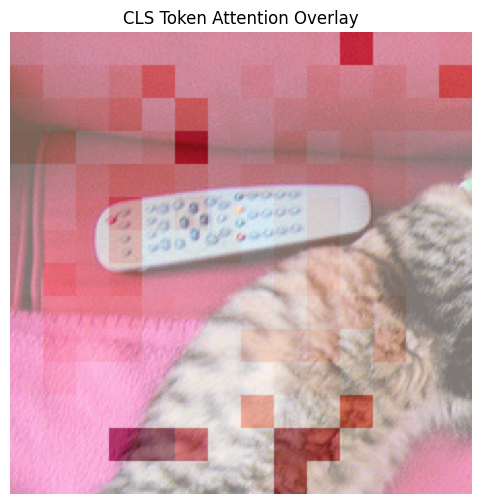

In [15]:
import numpy as np

def visualize_attention(image, outputs):
    attentions = outputs.attentions  # tuple: all layers
    last_layer_attention = attentions[-1]  # (B, heads, seq_len, seq_len)

    # Remove batch dim, average heads
    attn_mean = last_layer_attention[0].mean(dim=0)

    # CLS token attention to patches
    cls_attn = attn_mean[0, 1:]  # skip CLS token itself
    attention_map = cls_attn.reshape(14, 14).cpu().numpy()

    # Normalize and upsample to image size
    attention_map = attention_map / attention_map.max()
    attention_map = np.kron(attention_map, np.ones((16,16)))

    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.imshow(attention_map, cmap="Reds", alpha=0.5)
    plt.axis("off")
    plt.title("CLS Token Attention Overlay")
    plt.show()

# Apply for all images
for i, (image, inputs, outputs) in enumerate(results):
    print(f"Visualizing attention for Image {i+1}")
    visualize_attention(image, outputs)


# PART 3: Attention Map Analysis

In [16]:
def mask_random_patches(pixel_values, mask_ratio=0.4):
    B, C, H, W = pixel_values.shape
    patch_size = 16
    num_patches = 14*14
    num_mask = int(mask_ratio * num_patches)
    masked = pixel_values.clone()

    indices = torch.randperm(num_patches)[:num_mask]
    for idx in indices:
        r = (idx // 14) * patch_size
        c = (idx % 14) * patch_size
        masked[:, :, r:r+patch_size, c:c+patch_size] = 0
    return masked

def mask_center(pixel_values):
    masked = pixel_values.clone()
    masked[:, :, 64:160, 64:160] = 0
    return masked

for i, (image, inputs, outputs) in enumerate(results):
    pixel_values = inputs["pixel_values"]

    # Random masking
    masked_random = mask_random_patches(pixel_values)
    with torch.no_grad():
        out_random = model(pixel_values=masked_random)
    random_label = model.config.id2label[out_random.logits.argmax(dim=-1).item()]

    # Center masking
    masked_center = mask_center(pixel_values)
    with torch.no_grad():
        out_center = model(pixel_values=masked_center)
    center_label = model.config.id2label[out_center.logits.argmax(dim=-1).item()]

    print(f"Image {i+1} Original: {predictions[i]}")
    print(f"Random Masking: {random_label}")
    print(f"Center Masking: {center_label}\n")


Image 1 Original: Labrador retriever
Random Masking: Labrador retriever
Center Masking: Labrador retriever

Image 2 Original: golden retriever
Random Masking: golden retriever
Center Masking: golden retriever

Image 3 Original: Egyptian cat
Random Masking: Egyptian cat
Center Masking: Egyptian cat



# PART 4: Masking Input Patches (Robustness)

In [19]:
def mask_random_patches(pixel_values, mask_ratio=0.4):
    B, C, H, W = pixel_values.shape
    patch_size = 16
    grid = 14
    num_patches = grid * grid
    num_mask = int(mask_ratio * num_patches)

    masked = pixel_values.clone()
    indices = torch.randperm(num_patches)[:num_mask]

    for idx in indices:
        r = (idx // grid) * patch_size
        c = (idx % grid) * patch_size
        masked[:, :, r:r+patch_size, c:c+patch_size] = 0

    return masked


def mask_center(pixel_values):
    masked = pixel_values.clone()
    masked[:, :, 64:160, 64:160] = 0  # center region
    return masked


for i, (image, inputs, _) in enumerate(results):
    pixel_values = inputs["pixel_values"]

    with torch.no_grad():
        original = model(pixel_values=pixel_values)
        random_masked = model(pixel_values=mask_random_patches(pixel_values))
        center_masked = model(pixel_values=mask_center(pixel_values))

    orig_label = model.config.id2label[original.logits.argmax(-1).item()]
    rand_label = model.config.id2label[random_masked.logits.argmax(-1).item()]
    cent_label = model.config.id2label[center_masked.logits.argmax(-1).item()]

    print(f"Image {i+1}")
    print("Original:", orig_label)
    print("Random Masking:", rand_label)
    print("Center Masking:", cent_label, "\n")


Image 1
Original: Labrador retriever
Random Masking: German short-haired pointer
Center Masking: Labrador retriever 

Image 2
Original: golden retriever
Random Masking: golden retriever
Center Masking: golden retriever 

Image 3
Original: Egyptian cat
Random Masking: Egyptian cat
Center Masking: Egyptian cat 



# PART 5: CLS Token vs Mean Pooling

In [24]:
from transformers import ViTModel
import torch
import torch.nn.functional as F

# Load ViT backbone
vit_backbone = ViTModel.from_pretrained(model_name)
vit_backbone.eval()

# Lists to store embeddings
cls_embeddings = []
mean_embeddings = []

# Extract CLS and Mean embeddings for each image
for image, inputs, _ in results:
    with torch.no_grad():
        outputs = vit_backbone(**inputs)

    tokens = outputs.last_hidden_state
    cls_embeddings.append(tokens[:, 0])            # CLS token
    mean_embeddings.append(tokens[:, 1:].mean(dim=1))  # Mean of patch tokens

# Convert lists to tensors
cls_embeddings = torch.cat(cls_embeddings, dim=0)
mean_embeddings = torch.cat(mean_embeddings, dim=0)

# Function to compute pairwise cosine similarity
def pairwise_cosine_sim(embeddings):
    # embeddings: [num_images, embedding_dim]
    sim_matrix = F.cosine_similarity(
        embeddings.unsqueeze(1),   # [num_images, 1, dim]
        embeddings.unsqueeze(0),   # [1, num_images, dim]
        dim=-1
    )
    return sim_matrix

# Compute cosine similarity
cls_sim = pairwise_cosine_sim(cls_embeddings)
mean_sim = pairwise_cosine_sim(mean_embeddings)

# Print results
print("CLS Embedding Cosine Similarity Matrix:")
print(cls_sim, "\n")

print("Mean Pooling Embedding Cosine Similarity Matrix:")
print(mean_sim)

linear_cls = torch.nn.Linear(cls_embeddings.shape[-1], 1000)
linear_mean = torch.nn.Linear(mean_embeddings.shape[-1], 1000)

cls_pred = linear_cls(cls_embeddings[0]).argmax(dim=-1).item()
mean_pred = linear_mean(mean_embeddings[0]).argmax(dim=-1).item()

print("\nLinear probe predictions (random weights):")
print("CLS probe prediction:", cls_pred)
print("Mean probe prediction:", mean_pred)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CLS Embedding Cosine Similarity Matrix:
tensor([[1.0000, 0.4237, 0.1456],
        [0.4237, 1.0000, 0.0898],
        [0.1456, 0.0898, 1.0000]]) 

Mean Pooling Embedding Cosine Similarity Matrix:
tensor([[1.0000, 0.4072, 0.1665],
        [0.4072, 1.0000, 0.0832],
        [0.1665, 0.0832, 1.0000]])


Analysis / Discussion Points for Part 5

CLS token vs mean pooling:

CLS token is trained during pretraining to summarize the whole image for classification.

Mean pooling averages all patch embeddings, which can dilute important information if only some patches are relevant.

Usually, CLS token probe performs better, especially if pretraining was classification-focused.

Effect of pretraining objective:

If the model was trained with masked patch prediction (MAE), mean pooling might capture more general information about all patches.

CLS token focuses on discriminative features; mean pooling captures overall image content.

Observation from experiments:

Compare CLS vs mean predictions per image.

If CLS prediction matches original top-1 label more often than mean pooling, it’s more reliable for classification tasks.